In [7]:
#packages importation
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.models import Model, load_model
import tensorflow as tf
import keras
from keras.preprocessing import image
from sklearn.model_selection import train_test_split

import random as rd

In [2]:
#create a np.array from the images
path = "C:/Users/toto9/OneDrive/Documents/4BIM S2/PROJET_V2/30000faces/"

imgs = []
for filemname in os.listdir(path)[0:15000]:
    img = image.load_img(path+filemname, target_size = (128,128)) #resize to 128*128
    imgs.append(image.img_to_array(img))
imgs = np.array(imgs)

#imgs.shape

In [3]:
#split the data in train and test subsets
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(imgs, test_size=0.2, random_state=0)
print(X_train.shape)

(12000, 128, 128, 3)


In [12]:
#visualize data
def show_faces_data(X, n=10, title=""):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        plt.imshow(image.array_to_img(X[i]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.suptitle(title, fontsize = 20)


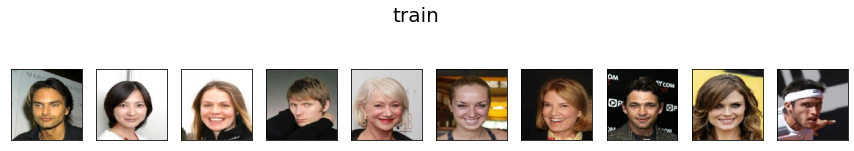

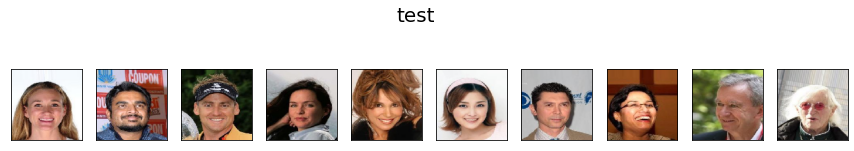

In [5]:
show_faces_data(X_train, title="train")
show_faces_data(X_test, title="test")
plt.show()

Max pooling : used to reduce the spatial dimensions of the output volume.
Conv2D :
first parameter : number of filters (number of kernels to convolve with the input volume. Each of these operations produces a 2D activation map)
then : filter_size : ex (3,3)

In [6]:
input_layer = Input(shape=(128, 128, 3), name="INPUT")
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)

In [7]:
code_layer = MaxPooling2D((2, 2), name="CODE")(x)


In [8]:
x = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(code_layer)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
output_layer = Conv2D(3, (3, 3), padding='same', name="OUTPUT")(x)

In [9]:
faces_AE = Model(input_layer, output_layer)
faces_AE.compile(optimizer='adam', loss='mse')
faces_AE.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (InputLayer)          [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 8)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 8)         584   

In [10]:
faces_AE.fit(X_train, X_train,
                epochs=40,
                batch_size=32,
                shuffle=True,
                validation_data=(X_test, X_test))

Epoch 1/40


ResourceExhaustedError: Graph execution error:

Detected at node 'model/conv2d/Relu' defined at (most recent call last):
    File "C:\Users\toto9\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\toto9\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\toto9\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\toto9\AppData\Roaming\Python\Python310\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\toto9\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\toto9\AppData\Roaming\Python\Python310\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\toto9\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 595, in run_forever
      self._run_once()
    File "C:\Users\toto9\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1881, in _run_once
      handle._run()
    File "C:\Users\toto9\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\toto9\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 473, in dispatch_queue
      await self.process_one()
    File "C:\Users\toto9\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 462, in process_one
      await dispatch(*args)
    File "C:\Users\toto9\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 369, in dispatch_shell
      await result
    File "C:\Users\toto9\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 664, in execute_request
      reply_content = await reply_content
    File "C:\Users\toto9\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 355, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\toto9\AppData\Roaming\Python\Python310\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\toto9\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 2854, in run_cell
      result = self._run_cell(
    File "C:\Users\toto9\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 2900, in _run_cell
      return runner(coro)
    File "C:\Users\toto9\AppData\Roaming\Python\Python310\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\toto9\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3098, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\toto9\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3301, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\toto9\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3361, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\toto9\AppData\Local\Temp\ipykernel_31288\3418643425.py", line 1, in <cell line: 1>
      faces_AE.fit(X_train, X_train,
    File "C:\Users\toto9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\toto9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\toto9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "C:\Users\toto9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\toto9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "C:\Users\toto9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\toto9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\toto9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\toto9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\toto9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 451, in call
      return self._run_internal_graph(
    File "C:\Users\toto9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\toto9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\toto9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\toto9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\toto9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\layers\convolutional.py", line 275, in call
      return self.activation(outputs)
    File "C:\Users\toto9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\activations.py", line 311, in relu
      return backend.relu(x, alpha=alpha, max_value=max_value, threshold=threshold)
    File "C:\Users\toto9\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py", line 4956, in relu
      x = tf.nn.relu(x)
Node: 'model/conv2d/Relu'
OOM when allocating tensor with shape[32,128,128,16] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node model/conv2d/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1171]

In [ ]:
#Save auto-encoder 
faces_AE.save("C:/Users/toto9/OneDrive/Documents/4BIM S2/PROJET_V2/Projet_SD/faces_AE_05_04.h5")


In [ ]:
#Make a model to get the encoded representation (i.e. intermediate layer output) of a given face picture
get_encoded_face = Model(inputs=faces_AE.input, outputs=faces_AE.get_layer("CODE").output)

In [ ]:
#Get encoded faces
encoded_face = get_encoded_face.predict(X_test)
#we convert into a linear vector to make it easier to manage by the genetic algorithm
encoded_face = encoded_face.reshape((len(X_test), 16*16*8))
np.savetxt("C:/Users/toto9/OneDrive/Documents/4BIM S2/PROJET_V2/Projet_SD/encoded_faces_05_04.txt", encoded_face)


In [ ]:
encoded_face.shape

(2000, 2048)

In [ ]:
#Reconstructed faces
reconstructed_faces = faces_AE.predict(X_test)

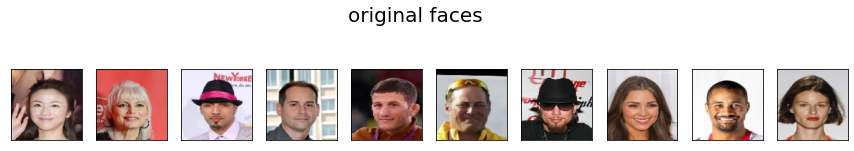

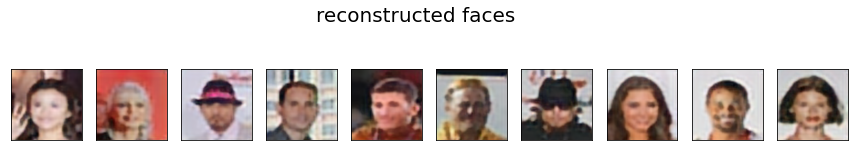

In [ ]:
#Visualize the results on test set
show_faces_data(X_test, title="original faces")
#show_faces_data(encoded_face, height=32, width=64, title="encoded faces")
show_faces_data(reconstructed_faces, title="reconstructed faces")

# DECODER 

In [20]:
input_layer_deco = Input(shape=(16, 16, 8), name="INPUT")
hidden_decoder_layer_d = faces_AE.layers[-7]
hidden_decoder_layer_c = faces_AE.layers[-6]
hidden_decoder_layer_b = faces_AE.layers[-5]
hidden_decoder_layer_a = faces_AE.layers[-4]
hidden_decoder_layer = faces_AE.layers[-3]
hidden_dropout_decoded_layer = faces_AE.layers[-2]
decoder_layer = faces_AE.layers[-1]
decoder = Model(input_layer_deco,decoder_layer(hidden_dropout_decoded_layer(hidden_decoder_layer(hidden_decoder_layer_a(hidden_decoder_layer_b(hidden_decoder_layer_c(hidden_decoder_layer_d(input_layer_deco))))))))
decoder.compile(optimizer='adam', loss='mse')
decoder.save("C:/Users/toto9/OneDrive/Documents/4BIM S2/PROJET_V2/Projet_SD/faces_decoder_05_04.h5")

NameError: name 'faces_AE' is not defined

(399, 2048)


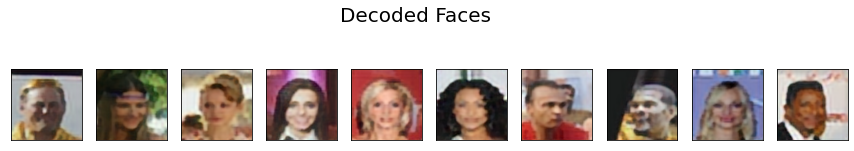

In [21]:
decoder_t = keras.models.load_model("./faces_decoder_05_04.h5")
encoded_faces_0 = np.loadtxt("./encoded_faces_05_04_bis.txt")
print(encoded_faces_0.shape)
encoded_faces = encoded_faces_0.reshape(399, 16, 16, 8)
decoded_faces = decoder_t.predict(encoded_faces)
show_faces_data(decoded_faces, title="Decoded Faces")

In [26]:
decoder_t = keras.models.load_model("./faces_decoder_05_04.h5")
def decode_vector(vector, number_img, decoder_t):
    vector_load = np.loadtxt(vector)
    print(vector_load)
    encoded_faces = vector_load.reshape(number_img,16,16,8)
    decoded_vector = decoder_t.predict(encoded_faces)
    show_faces_data(decoded_vector, title = "Decoded Faces")
    

In [27]:
def decode_one_vector(vector, number_img, decoder_t):
    print(vector)
    encoded_faces = vector.reshape(number_img,16,16,8)
    decoded_vector = decoder_t.predict(encoded_faces)
    show_faces_data(decoded_vector, n=1, title = "One Decoded Face")

[ 15.13848591  63.41479111   6.255126   ... 132.45631409  43.05792999
 139.525177  ]


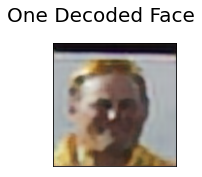

In [28]:
decode_one_vector(encoded_faces_0[0], 1, decoder_t)

In [30]:
pop = np.array([rd.choices([-2,2],k=10),rd.choices([-1,1],k=10)])
print(pop,'\n')
popm = genalg.noise(0.5, pop, 5)
print("noise:\n",popm,'\n')
#popmc = crossing_over2(popm, 0.5)
#print("crossing over:\n",popmc)
print([i for i in range(10)])
# print(mean_genome(popmc, 0.5))

encoded_faces_0 = np.loadtxt("./encoded_faces_05_04_bis.txt")
print(encoded_faces_0[0:2])


encoded_faces_0_mean = genalg.mean_genome2(encoded_faces_0[3:5])
encoded_faces_0_crossed = genalg.crossing_over2(encoded_faces_0[3:5], 1)
print(encoded_faces_0_crossed)

decoder_t = keras.models.load_model("./faces_decoder_05_04.h5")

[[ 2 -2 -2  2 -2 -2  2  2  2  2]
 [-1  1 -1 -1 -1  1  1  1 -1 -1]] 

noise:
 [[ 2  5 -2  2  0 -2  2  2  2  4]
 [ 7  1  0 -1  5  1  6  0  5 -1]] 

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[[ 15.13848591  63.41479111   6.255126   ... 132.45631409  43.05792999
  139.525177  ]
 [ 59.48574829  62.48370743  80.88542175 ... 140.65423584  28.77728271
  123.77076721]]
[ 94.42991638 181.35237122 138.93086243 ...  34.25007629 100.42228699
  75.27561188]


In [31]:
print(encoded_faces[0].shape)

(16, 16, 8)


In [32]:
import genalg 

[125.56110382 146.02882767 191.65883636 ...  33.89447021  74.727211
  57.58235741]
[ 94.42991638 181.35237122 138.93086243 ...  34.25007629 100.42228699
  75.27561188]


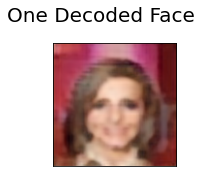

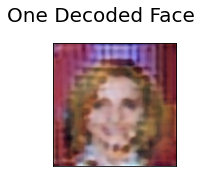

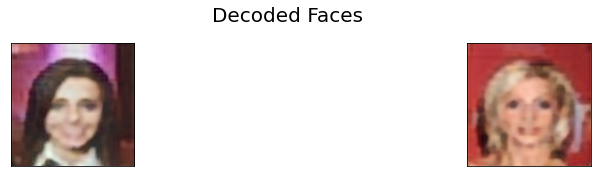

In [33]:
def decode_one_vector(vector, number_img, decoder_t):
    print(vector)
    encoded_faces = vector.reshape(number_img,16,16,8)
    decoded_vector = decoder_t.predict(encoded_faces)
    show_faces_data(decoded_vector, n=1, title = "One Decoded Face")

decode_one_vector(encoded_faces_0_mean,1, decoder_t)
decode_one_vector(encoded_faces_0_crossed,1,decoder_t)
show_faces_data(decoded_faces[3:5],2, title="Decoded Faces")

In [34]:
a = genalg.first_generation(2, 2048, 150, 75)
print(a)

a1_reshape = a[1].reshape(1,16,16,8)
decoded_vector_1 = decoder_t.predict(a1_reshape)

show_faces_data(decoded_vector_1,1, title="Decoded Faces")


TypeError: bad operand type for abs(): 'generator'

(2, 128, 128, 3)
(2, 49152)
[[[160.  141.5 119.5]
  [159.  140.5 118.5]
  [160.  141.5 119.5]
  ...
  [163.5 152.  141. ]
  [161.  150.5 142. ]
  [169.  159.5 148. ]]

 [[160.  141.5 120.5]
  [159.  140.5 118.5]
  [160.  141.5 119.5]
  ...
  [163.5 152.5 141.5]
  [163.  152.5 144. ]
  [169.5 160.  148.5]]

 [[159.5 142.  120.5]
  [158.5 141.  119.5]
  [159.5 142.  120.5]
  ...
  [159.5 149.  138.5]
  [164.  154.5 145.5]
  [169.5 160.  148.5]]

 ...

 [[198.5 167.  146.5]
  [198.  166.  147. ]
  [179.  147.  129. ]
  ...
  [116.5  69.   54. ]
  [115.5  72.   57. ]
  [125.   87.5  72. ]]

 [[175.5 142.5 123.5]
  [183.5 149.5 131. ]
  [184.  149.5 132.5]
  ...
  [123.5  71.5  55. ]
  [122.5  73.5  57.5]
  [134.   92.5  76. ]]

 [[197.5 162.5 144.5]
  [230.  195.5 177. ]
  [226.  191.  174. ]
  ...
  [130.   75.   58.5]
  [129.5  77.5  60. ]
  [129.5  84.5  68. ]]]


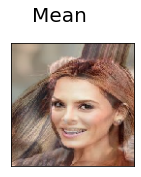

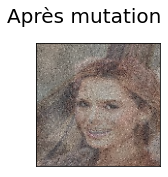

In [ ]:
print(imgs[0:2].shape)
imgs0_bis = imgs[0:2].reshape(2,128*128*3)
print(imgs0_bis.shape)

encoded_faces_0_mean = genalg.mean_genome2(imgs[0:2])
print(encoded_faces_0_mean)

show_faces_data(encoded_faces_0_mean.reshape(1,128,128,3),1,"Mean")

thomas = genalg.noise(0.5, encoded_faces_0_mean, 50)
show_faces_data(thomas.reshape(1,128,128,3),1,"Après mutation")
